In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, 
precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from scipy import stats

In [3]:
sleep = pd.read_csv('C:\\Users\\LENOVO\\Desktop\\DS PROJECT\\sleep.csv')


In [4]:
print(sleep.describe(include='all'))


          Person ID Gender          Age Occupation  Sleep Duration  \
count   1496.000000   1496  1496.000000       1496     1496.000000   
unique          NaN      2          NaN         11             NaN   
top             NaN   Male          NaN      Nurse             NaN   
freq            NaN    756          NaN        292             NaN   
mean     748.500000    NaN    42.184492        NaN        7.132086   
std      432.002315    NaN     8.664427        NaN        0.794858   
min        1.000000    NaN    27.000000        NaN        5.800000   
25%      374.750000    NaN    35.000000        NaN        6.400000   
50%      748.500000    NaN    43.000000        NaN        7.200000   
75%     1122.250000    NaN    50.000000        NaN        7.800000   
max     1496.000000    NaN    59.000000        NaN        8.500000   

        Quality of Sleep  Physical Activity Level  Stress Level BMI Category  \
count        1496.000000              1496.000000   1496.000000         1496   

In [5]:
print(sleep.isnull().sum())


Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             876
dtype: int64


In [6]:
sleep['Sleep Disorder'] = sleep['Sleep Disorder'].fillna('None')


In [7]:
sleep.replace("Normal Weight", "Normal", inplace=True)


In [8]:
encoder = LabelEncoder()
categorical_cols = ['Gender', 'Occupation', 'BMI Category', 'Blood Pressure', 'Sleep Disorder']

for col in categorical_cols:
    sleep[f'{col}_Label'] = encoder.fit_transform(sleep[col])

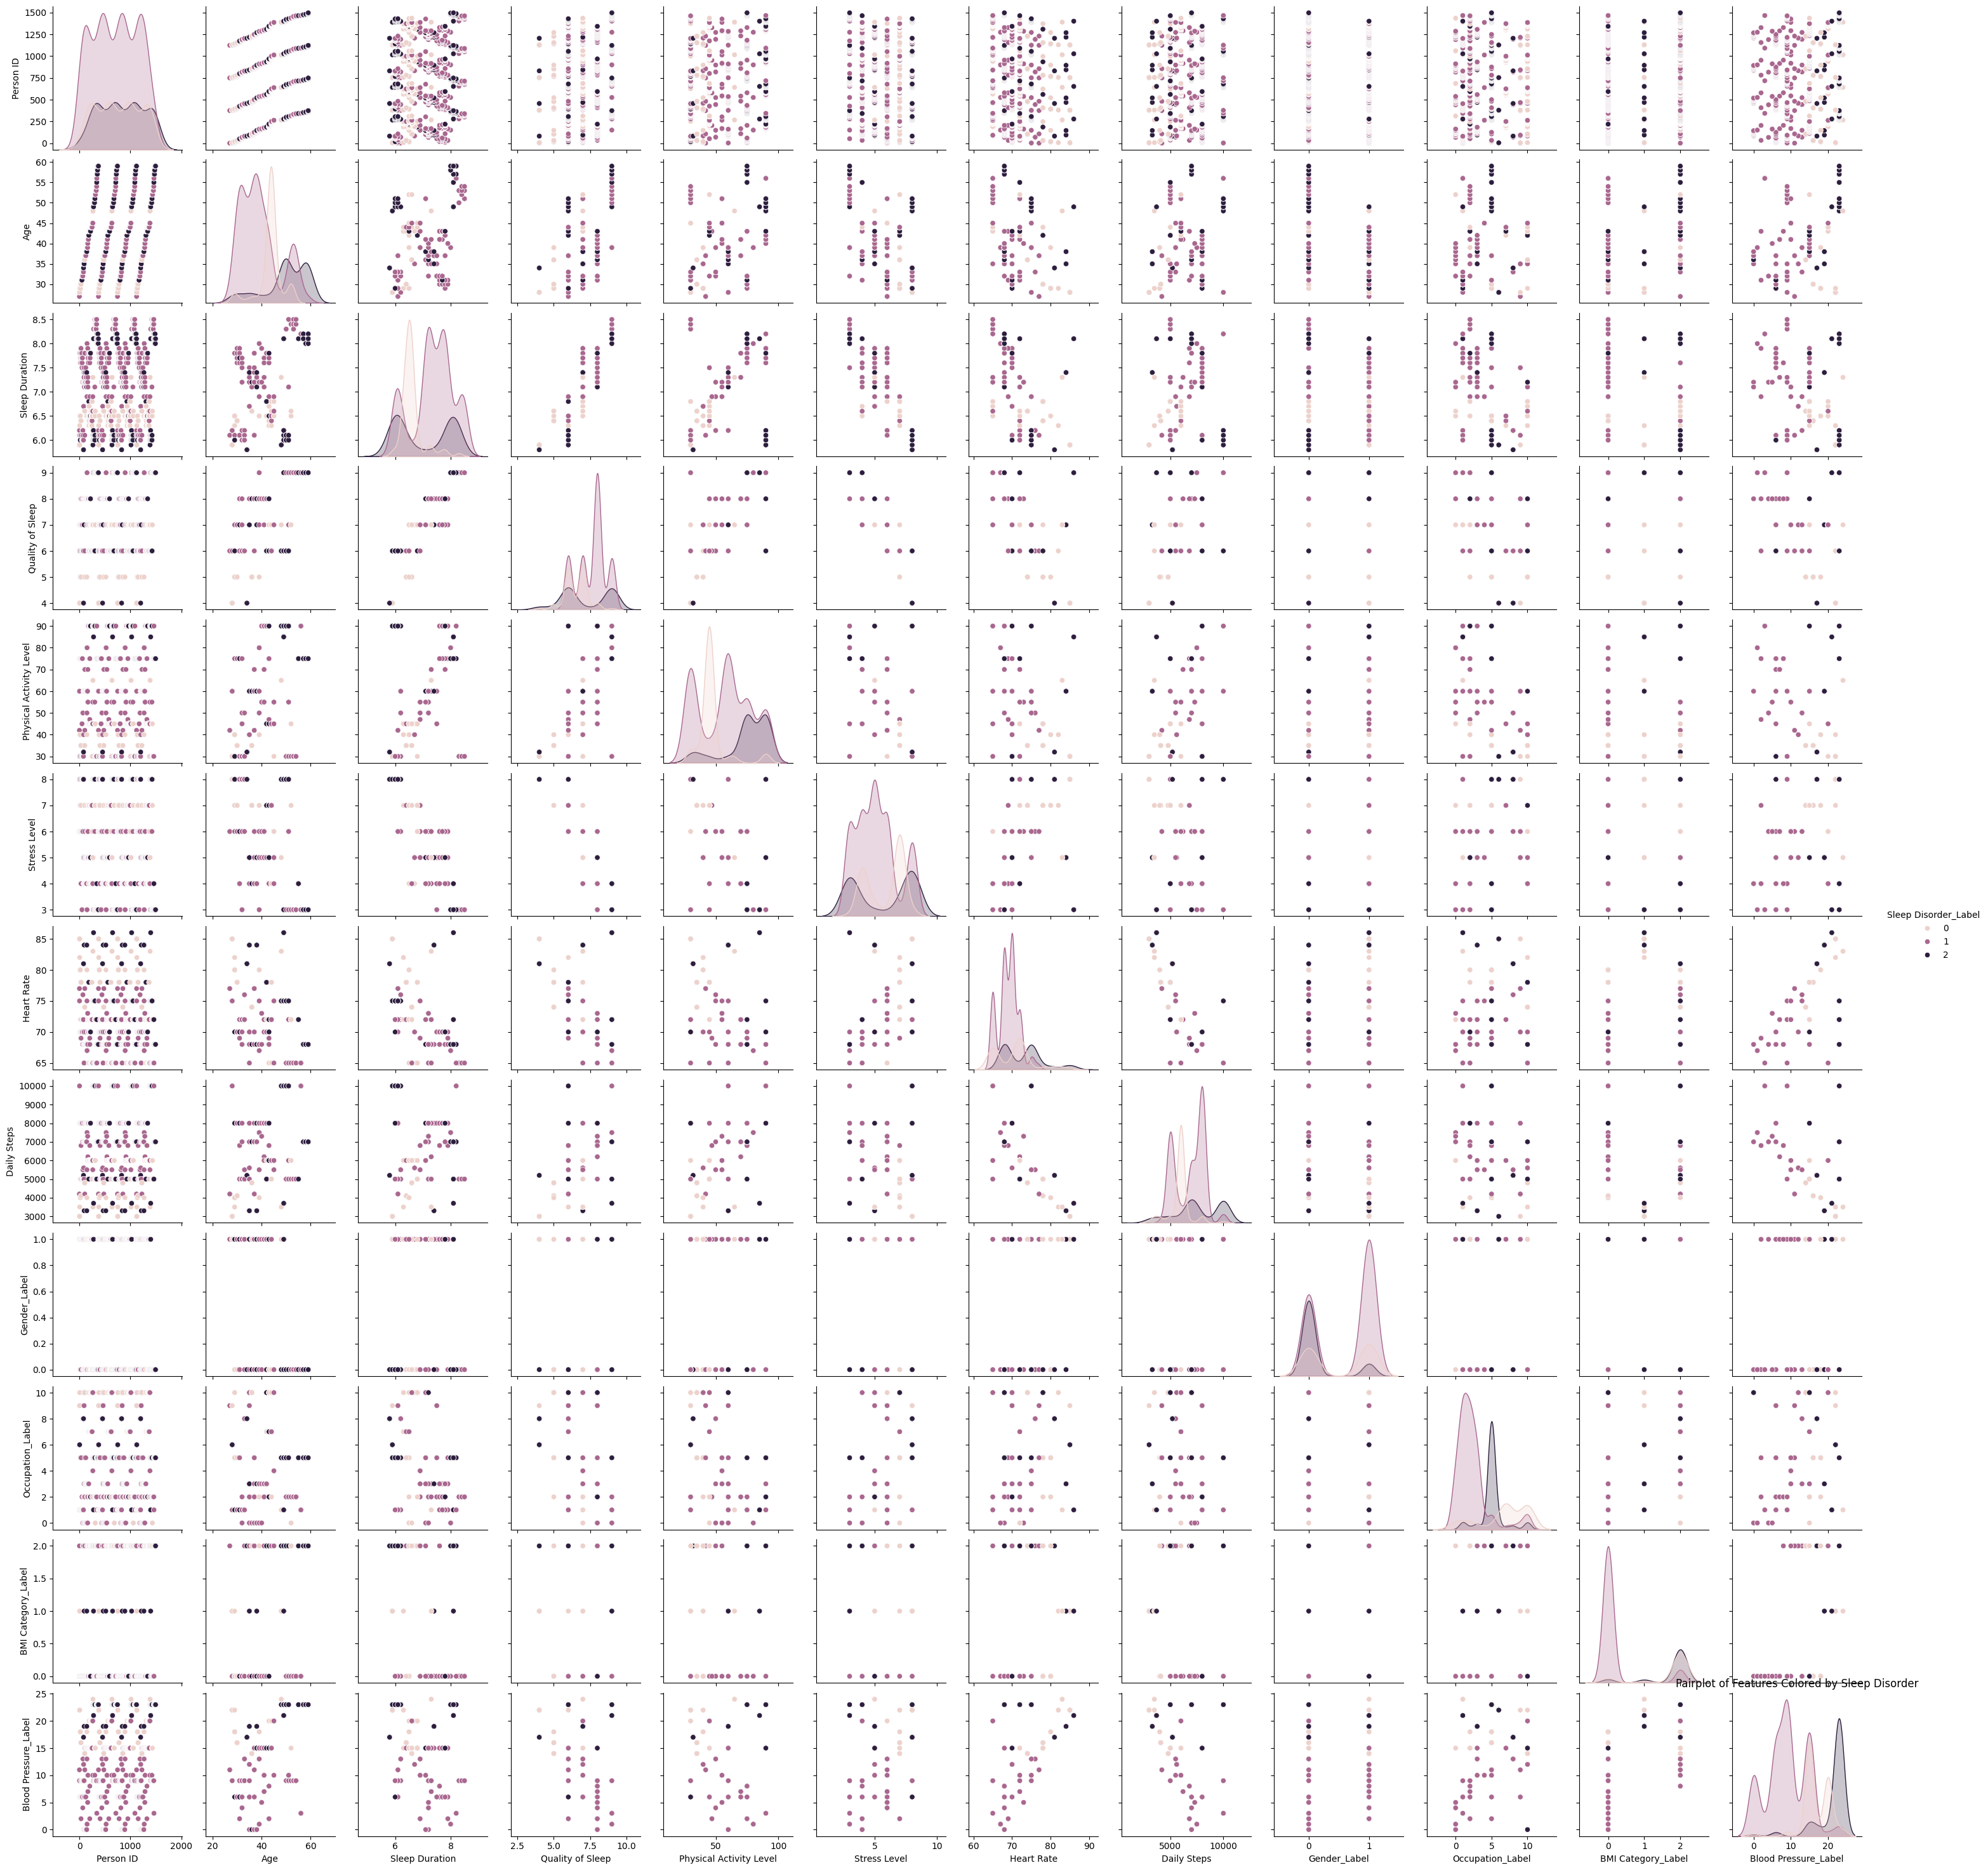

In [9]:
sns.pairplot(sleep, hue='Sleep Disorder_Label', diag_kind='kde')
plt.title('Pairplot of Features Colored by Sleep Disorder')
plt.show()


In [10]:
sleep.drop(['Gender', 'Occupation', 'BMI Category', 'Blood Pressure', 'Sleep Disorder', 'Person ID'], axis=1, 
           inplace=True)


In [11]:
sleep['Stress_Activity_Ratio'] = sleep['Stress Level'] / sleep['Physical Activity Level']


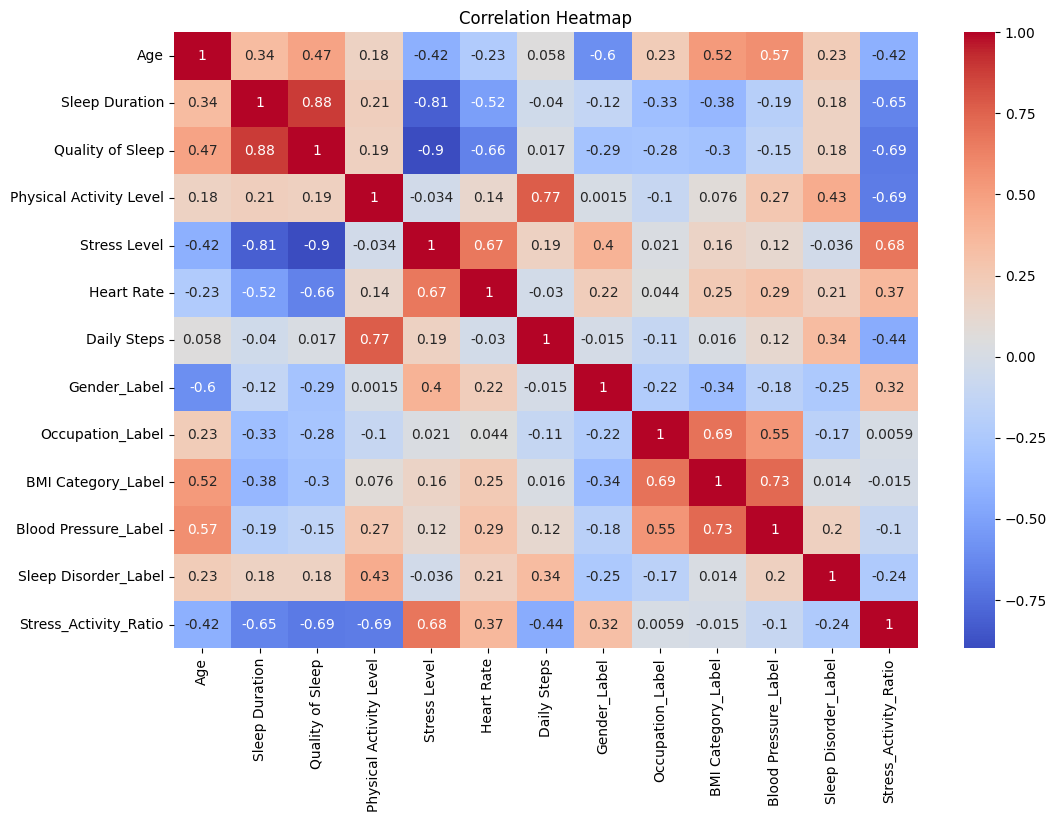

In [12]:
plt.figure(figsize=(12, 8))
sns.heatmap(sleep.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [16]:
sleep = sleep[(np.abs(stats.zscore(sleep.select_dtypes(include=[np.number]))) < 3).all(axis=1)]


In [17]:
X = sleep.drop('Sleep Disorder_Label', axis=1)
y = sleep['Sleep Disorder_Label']

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
smote = SMOTE()
X_res, y_res = smote.fit_resample(X_scaled, y)

In [21]:
selector = SelectKBest(f_classif, k=10)
X_new = selector.fit_transform(X_res, y_res)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_res, test_size=0.3, random_state=42)

In [23]:
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)


Train set: (1839, 10) (1839,)
Test set: (789, 10) (789,)


In [24]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy of {name} is = {accuracy * 100:.2f}%')


Accuracy of Logistic Regression is = 87.33%
Accuracy of Random Forest is = 90.49%
Accuracy of Gradient Boosting is = 89.73%


In [25]:
voting_clf = VotingClassifier(estimators=[
    ('lr', models['Logistic Regression']), 
    ('rf', models['Random Forest']), 
    ('gb', models['Gradient Boosting'])], voting='soft')

In [26]:
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                             ('rf', RandomForestClassifier()),
                             ('gb', GradientBoostingClassifier())],
                 voting='soft')

In [27]:
y_pred_voting = voting_clf.predict(X_test)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print('Accuracy of Voting Classifier is =', accuracy_voting * 100)

Accuracy of Voting Classifier is = 89.86058301647655


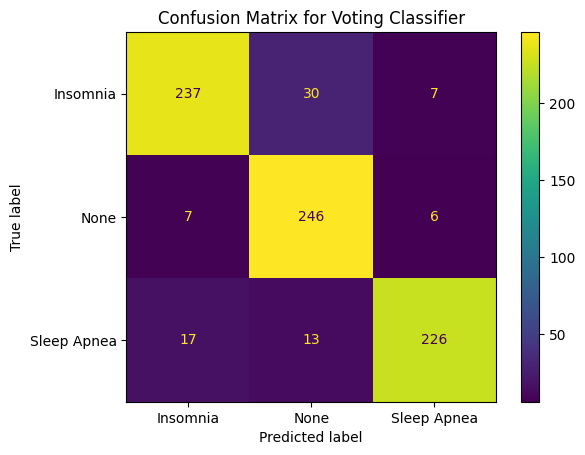

In [28]:
cm = confusion_matrix(y_test, y_pred_voting)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
cm_display.plot()
plt.title('Confusion Matrix for Voting Classifier')
plt.show()


In [29]:
precision = precision_score(y_test, y_pred_voting, average='weighted')
recall = recall_score(y_test, y_pred_voting, average='weighted')
f1 = f1_score(y_test, y_pred_voting, average='weighted')
roc_auc = roc_auc_score(y_test, voting_clf.predict_proba(X_test), multi_class='ovo')


In [30]:
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)
print('ROC-AUC:', roc_auc)

Precision: 0.9015761461707859
Recall: 0.8986058301647655
F1-Score: 0.8986734364786028
ROC-AUC: 0.9824961935263601
